In [ ]:
import pandas as pd
from pathlib import Path
from utils.data_loading import SGCCDataset
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from predict_func import *

# 设置参数

In [2]:
data_name = 'SGCC'
attack_id = 4
val_percent = 0.1
model_name = 'UNet_1D'
model = 'best_checkpoint.pth'
dir_checkpoint = Path(f'./checkpoints_pseudo_{data_name}/')

# 准备数据

In [3]:
zx3_normalized = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/zx{attack_id}_normalized.csv') 
normal3_normalized = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/Normal3_normalized.csv')
# Rename the columns of df2 to match df1
normal3_normalized.columns = zx3_normalized.columns

zy3 = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/zy{attack_id}.csv') 
normal3_normalized_label = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/Normal3_normalized_label.csv')
normal3_normalized_label.columns = zy3.columns

combined_dfx = pd.concat([zx3_normalized, normal3_normalized], ignore_index=True)#
combined_dfy = pd.concat([zy3, normal3_normalized_label], ignore_index=True)#


combined_dfx.to_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfx.csv', index=False)
combined_dfy.to_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfy.csv', index=False)

normal3_normalized_pseudolabel2 = pd.read_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/Normal3_normalized_pseudolabel.csv')
normal3_normalized_pseudolabel2.columns = zy3.columns
combined_dfy_pseudo2 = pd.concat([zy3, normal3_normalized_pseudolabel2], ignore_index=True)#
combined_dfy_pseudo2.to_csv(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfy_pseudo.csv', index=False)

# %%
combined_dfy_pseudo2.shape

# %%
##### testing 用的predict_t.py
# data_name = ''
##### 改变的地方是：
dir_data = Path(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfx.csv')
# dir_mask = Path('./combined_dfy.csv')
dir_mask = Path(f'./data/{data_name}_data/data_prepared_{attack_id}/combined_dfy_pseudo.csv')
dataset = SGCCDataset(dir_data, dir_mask)

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

data = dataset.data_tensor
mask = dataset.mask_tensor

data_train = torch.tensor(np.array([train_set[i]['data'] for i in range(len(train_set))]).squeeze())
mask_train = torch.tensor(np.array([train_set[i]['mask'] for i in range(len(train_set))]).squeeze())

data_val = torch.tensor(np.array([val_set[i]['data'] for i in range(len(val_set))]).squeeze())
mask_val = torch.tensor(np.array([val_set[i]['mask'] for i in range(len(val_set))]).squeeze())

# 查看输入数据和标签的 size

In [4]:
data_val.shape, mask_val.shape

(torch.Size([302, 304]), torch.Size([302, 304]))

# 调用预测函数

In [5]:
mask_pred = predict_mask(data_val)

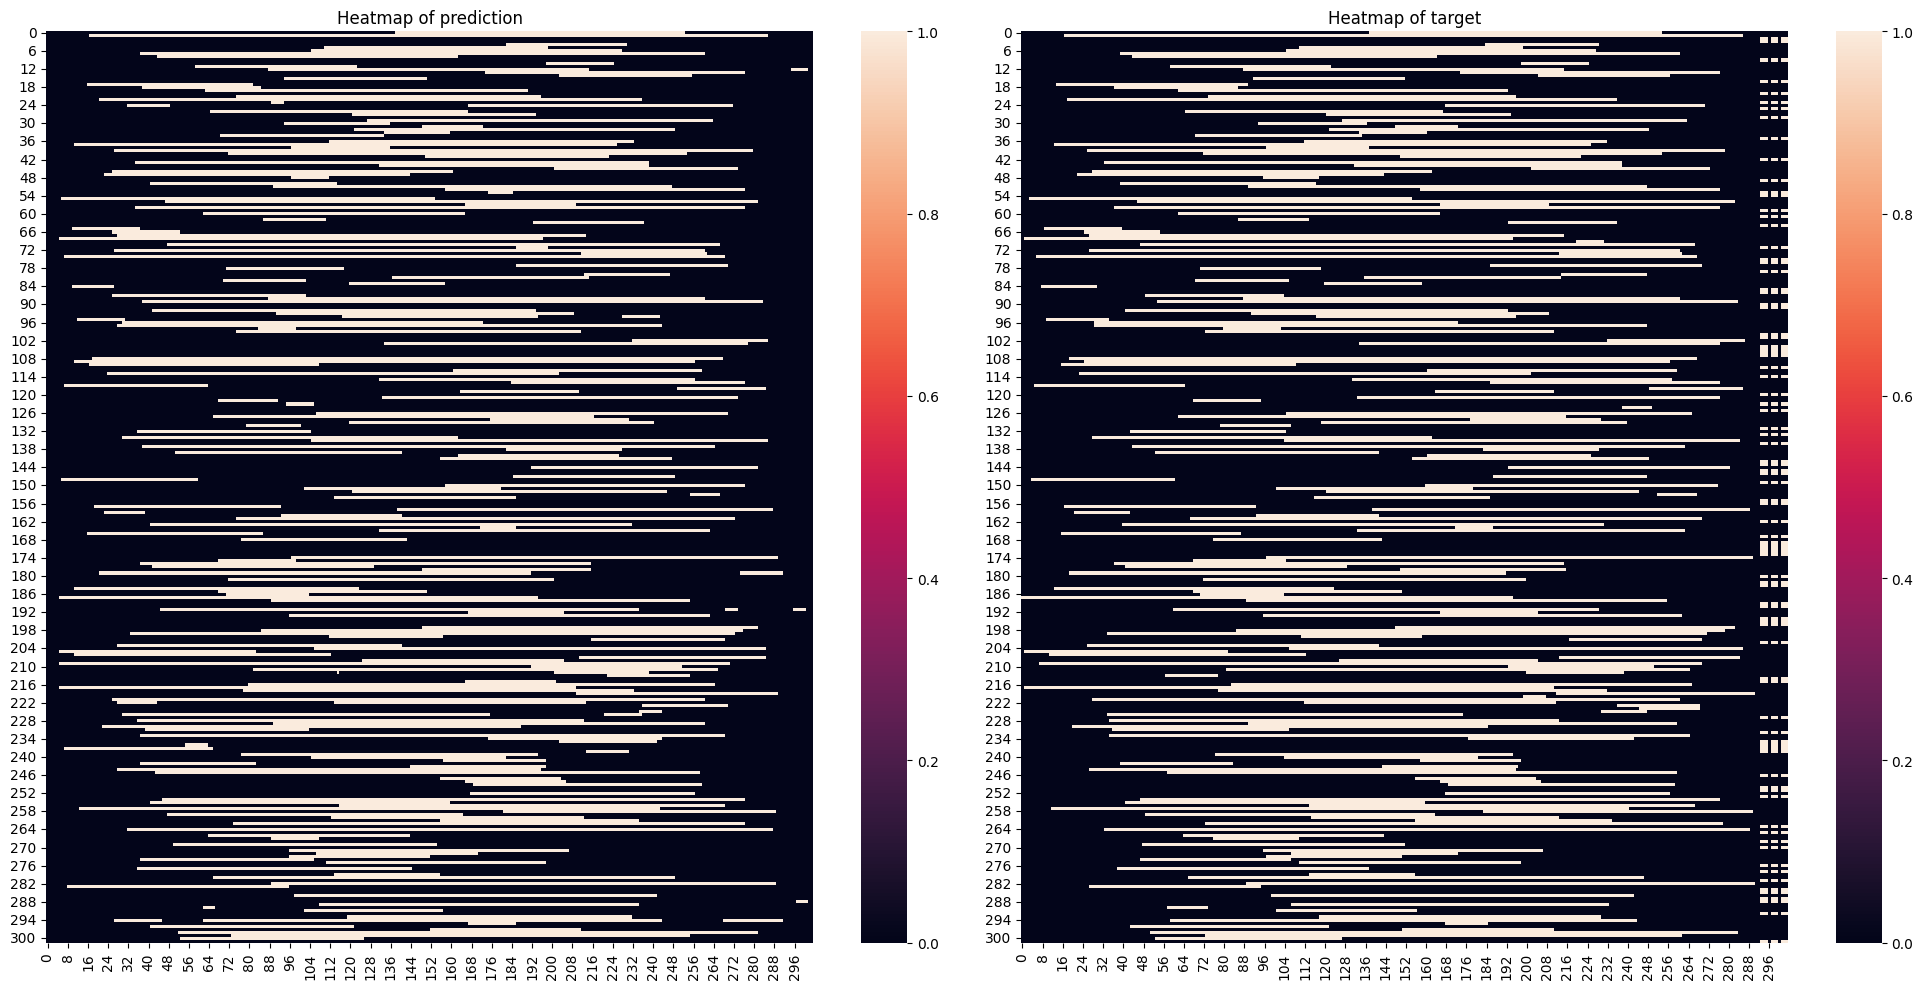

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(mask_pred, ax=ax1)
ax1.set_title('Heatmap of prediction')
sns.heatmap(mask_val, ax=ax2)
ax2.set_title('Heatmap of target')
plt.tight_layout()

In [7]:
mask_pred.shape

(302, 304)

In [8]:
def mark_continuous_ones(data, threshold=7):
    df_data = pd.DataFrame(data)
    def has_continuous_ones(row):
        count = 0
        for value in row:
            if value == 1:
                count += 1
                if count >= threshold:
                    return True
            else:
                count = 0
        return False

    return df_data.apply(has_continuous_ones, axis=1)

In [9]:
mask_pred_marked = mark_continuous_ones(mask_pred, threshold=7)
mask_marked = mark_continuous_ones(mask_val, threshold=7)
mask_pred_marked.shape, mask_marked.shape

((302,), (302,))

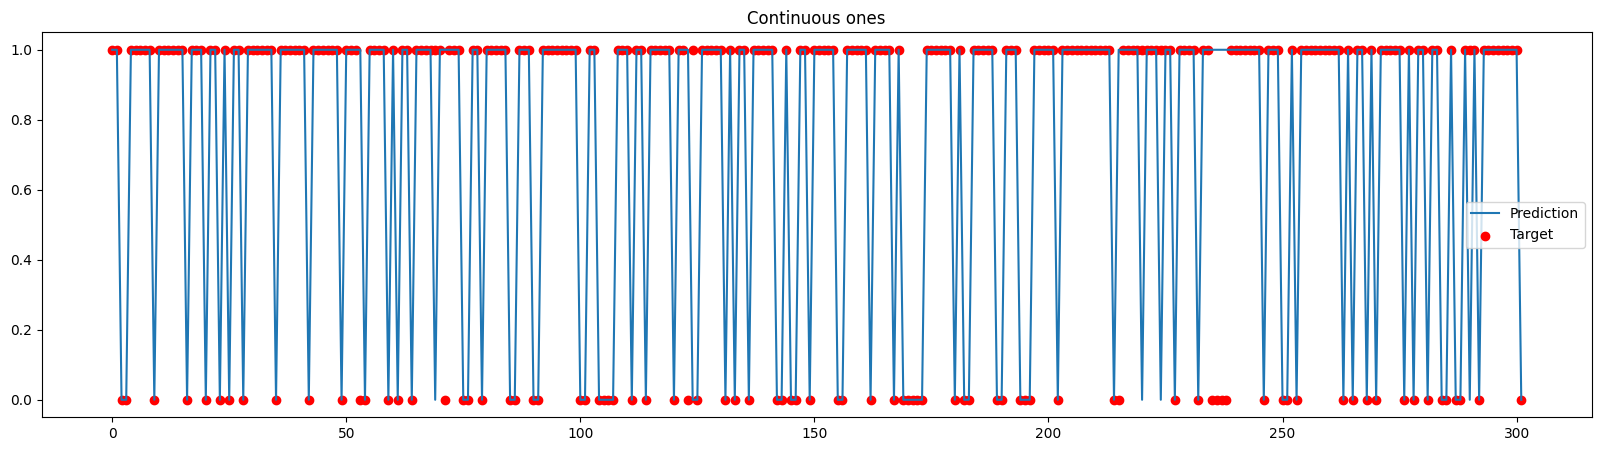

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(mask_pred_marked, label='Prediction')
plt.scatter(np.arange(len(mask_marked)), mask_marked, label='Target', color='red')
plt.title('Continuous ones')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

# Calculate accuracy
accuracy = accuracy_score(mask_marked, mask_pred_marked)

# Calculate F1 score
f1 = f1_score(mask_marked, mask_pred_marked)

# Calculate recall
recall = recall_score(mask_marked, mask_pred_marked)

auc = roc_auc_score(mask_marked, mask_pred_marked)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')


Accuracy: 0.956953642384106
F1 Score: 0.9701149425287356
Recall: 0.9768518518518519
AUC: 0.9419142980189493
